# nnUNet - CREATE
---
#### Joey Spronck

This notebook will guide you through all the steps required to train the top-performing nnUNet configuration on the segmentation component of the TIGER challenge. This configuration achieved the #1 ranking on the experimental test set during the first attempt. We are currently in the process of publishing our paper detailing our results. https://openreview.net/forum?id=aHuwlUu_QR

This notebook only contains code for nnUNet_v1. Soon we'll release nnUNet_v2 code with additional features (such as dynamic dataloaders) in the main branch of our nnUNet-for-pathology GitHub repo. 

# Outline
- First you will need to download the TIGER training data
- Adjust the paths according to your setup and ceate a task name and create the folders (default nnUNet folder structure is required, check its documentation)
- Once set up, we'll use a loop to:
    - Visualise the ROIs and the corresponding annotations to check whether they load correctly
    - Gather label pixel counts and add them to a dataframe
- The counts dataframe is later used to define a 5-fold split with balanced label abundance in every fold
    - You'll have the option to split every ROI individually, or split based on WSI which groups ROIs from the same WSI in the train or test set (preferred)
- We'll write train images and label masks in nifti format
- We'll create the dataset.json
- Finally you will have a set of trainers and experiment planners to chose from. The best configuration (on a GPU of 11GB) was:
    - Trainer: 'nnUNetTrainerV2_BN_pathology_DA_ignore0_hed005'
        - Which used batch norm (BN) instead of intance norm (IN)
        - Ignores label 0, which is unannotated in TIGER data
        - Uses additional HED augmentation
    - Experiment planner: 'ExperimentPlanner2D_v21_RGB_scaleTo_0_1_bs8_ps512'
        - Scales RGB ton 0-1 instead of applying z-score norm
        - Uses a batch size of 8 and a patch size of 512x512
            - In another dataset nnUNet automatically came up with a patch size of 1024x1024 and a batch size of 2. In our beforementioned paper we've shown that for pathology data a bigger batch size and with that smaller patch size is benifitial (especially in combination with batch norm)
- The notebook shows you the required commands to:
    - plan the experiment and preprocess the nifti files
    - train the specified configuration 

# Download TIGER data

First you will need to download the prublicly available TIGER dataset through AWS CLI Access (No AWS account required).

Check out the follwing link:
https://registry.opendata.aws/tiger/

Install the AWS CLI on your system and run the following command to see the available data: 

##### *aws s3 ls --no-sign-request s3://tiger-training/*

In this notebook you'll have the option to work with the *wsi-level-annotations* (containing the full WSI and corresponding xml annotations) or the *roi-level-annotations* directly containing png's from the ROIs and the masks used for training.

You can download both types of data using:

#### All

##### *aws s3 cp --no-sign-request --recursive s3://tiger-training/wsirois/ /add/your/path/here/wsirois*

similarly you can only download the wsi or roi level data as follows:

#### ROI
##### *aws s3 cp --no-sign-request --recursive s3://tiger-training/wsirois/roi-level-annotations/tissue-cells /add/your/path/here/wsirois/roi-level-annotations/tissue-cells*

#### WSI
##### *aws s3 cp --no-sign-request --recursive s3://tiger-training/wsirois/wsi-level-annotations/images/ /add/your/path/here/wsirois/wsi-level-annotations/images/*

and

##### *aws s3 cp --no-sign-request --recursive s3://tiger-training/wsirois/wsi-level-annotations/annotations-tissue-cells-xmls/ /add/your/path/here/wsirois/wsi-level-annotations/annotations-tissue-cells-xmls/*





#### *For speed purposes it is advised to run the ROI based code (default), but feel free to download the WSI based data and uncomment the WSI code as well. However, once you export the nifti files required by nnUNet, make sure you are not exporting nifti files from both approaches into the same train folder, as this will cause duplicates in the train data used by nnUNet*

# Libraries

In [1]:
import os


from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import SimpleITK as sitk
import yaml
from pathlib import Path
from PIL import Image
import json
import re
import pickle 

Uncomment below if you want to use WSI + xml data instead of using the ROI and mask png's

In [2]:
# !pip install wholeslidedata==0.0.15
# !pip install shapely==1.7.1
### you'll probably also need to install openslide if an import doesnt work
# # os.add_dll_directory(r"C:\Program Files\openslide\bin") # windows
# from wholeslidedata.annotation.wholeslideannotation import WholeSlideAnnotation
# from wholeslidedata.image.wholeslideimage import WholeSlideImage
# from wholeslidedata.accessories.asap.parser import AsapAnnotationParser
# from wholeslidedata.samplers.patchlabelsampler import SegmentationPatchLabelSampler
# from shapely.geometry import Point

In [3]:
def load_pickle(file: str, mode: str = 'rb'):
    with open(file, mode) as f:
        a = pickle.load(f)
    return a

def write_pickle(obj, file: str, mode: str = 'wb') -> None:
    with open(file, mode) as f:
        pickle.dump(obj, f)

---
---
# Set your paths here

In [4]:
tiger_yaml_path = 'temp_stuff/tigersegmentationdata.yml'

tiger_data_folder = '/data/pathology/projects/tiger/new_structure/training/wsirois'
replace_root = tiger_data_folder

nnUNet_base = '/data/pathology/projects/pathology-lung-TIL/nnUNet_raw_data_base'
preprocessed_root = '/data/pathology/projects/pathology-lung-TIL/nnUNet_raw_data_base/nnUNet_preprocessed'

### Print tasks

In [5]:
nnUNet_data_root = os.path.join(nnUNet_base, "nnUNet_raw_data")
sorted(os.listdir(nnUNet_data_root))

['Task001_Lung_tissue_segmentation_first',
 'Task002_Lung_tissue_segmentation_raw_ROIs',
 'Task003_Lung_tissue_segmentation_raw_ROIs_corrected',
 'Task004_lowres_spacing4_Lung_tissue_segmentation',
 'Task005_lowres_spacing2_ignore_label0_Lung_tissue_segmentation',
 'Task006_highres_FOLD0_lowres_from_task005_Lung_tissue_segmentation',
 'Task007_highres_FOLD1_lowres_from_task005_Lung_tissue_segmentation',
 'Task008_highres_FOLD2_lowres_from_task005_Lung_tissue_segmentation',
 'Task009_highres_FOLD3_lowres_from_task005_Lung_tissue_segmentation',
 'Task010_highres_FOLD0_lowres_SOFTMAX_and_NOISE_from_task005_Lung_tissue_segmentation',
 'Task011_highres_FOLD1_lowres_SOFTMAX_and_NOISE_from_task005_Lung_tissue_segmentation',
 'Task012_highres_FOLD2_lowres_SOFTMAX_and_NOISE_from_task005_Lung_tissue_segmentation',
 'Task013_highres_FOLD3_lowres_SOFTMAX_and_NOISE_from_task005_Lung_tissue_segmentation',
 'Task014_merged_classes_T_TAS_O_N',
 'Task015_batch2_added_to_train_pathology_DA1',
 'Task016_

# Create your task

### Set your task name here (with an id that is not taken yet)
for example: Task001_TIGER_challenge

In [6]:
task_name = 'Task027_TIGER_public_test'
task_id = re.match('Task([0-9]+)', task_name).group(1)

In [7]:
task_root = os.path.join(nnUNet_data_root, task_name)
print("TASK:\t\t", task_name)
print("nnUNet ROOT:\t", nnUNet_base)
image_folder = os.path.join(task_root, "imagesTr")
label_folder = os.path.join(task_root, "labelsTr")
label_folder

TASK:		 Task027_TIGER_public_test
nnUNet ROOT:	 /data/pathology/projects/pathology-lung-TIL/nnUNet_raw_data_base


'/data/pathology/projects/pathology-lung-TIL/nnUNet_raw_data_base/nnUNet_raw_data/Task027_TIGER_public_test/labelsTr'

### Make folders

In [8]:
os.makedirs(image_folder, exist_ok=True)
os.makedirs(label_folder, exist_ok=True)

---
---
# Data import

In [9]:
with open(tiger_yaml_path) as f:
    tiger_yaml = yaml.safe_load(f)

In [10]:
# Same file
# import requests
# r = requests.get('https://raw.githubusercontent.com/DIAGNijmegen/pathology-whole-slide-data/main/docs/source/userguide/notebooks/examples/configs/tigersegmentationdata.yml')
# tiger_yaml = yaml.safe_load(r.text)

### Matches per WSI|

These are the 195 WSIs and the corresponding XML annotations (possibly containing multiple ROIs)

In [11]:
train_image_anno = [(entry['wsi']['path'].replace('/home/user', replace_root), entry['wsa']['path'].replace('/home/user', replace_root)) for entry in tiger_yaml['training']]
print(len(train_image_anno))
train_image_anno[:4]

195


[('/data/pathology/projects/tiger/new_structure/training/wsirois/wsi-level-annotations/images/100B.tif',
  '/data/pathology/projects/tiger/new_structure/training/wsirois/wsi-level-annotations/annotations-tissue-cells-xmls/100B.xml'),
 ('/data/pathology/projects/tiger/new_structure/training/wsirois/wsi-level-annotations/images/114S.tif',
  '/data/pathology/projects/tiger/new_structure/training/wsirois/wsi-level-annotations/annotations-tissue-cells-xmls/114S.xml'),
 ('/data/pathology/projects/tiger/new_structure/training/wsirois/wsi-level-annotations/images/122S.tif',
  '/data/pathology/projects/tiger/new_structure/training/wsirois/wsi-level-annotations/annotations-tissue-cells-xmls/122S.xml'),
 ('/data/pathology/projects/tiger/new_structure/training/wsirois/wsi-level-annotations/images/133S.tif',
  '/data/pathology/projects/tiger/new_structure/training/wsirois/wsi-level-annotations/annotations-tissue-cells-xmls/133S.xml')]

##### Simple check if replace dict is done right
If you want to use the WSI and xml data, this needs to be true

In [12]:
os.path.isfile(train_image_anno[0][0])

True

### Matches per ROI

We also have the 286 ROI images and annotation masks directly. These are used in this experiment, because loading them directly is faster than loading the ROIs and masks from the WSI

In [ ]:
train_image_anno = [(entry['wsi']['path'].replace('/home/user', replace_root), entry['wsa']['path'].replace('/home/user', replace_root)) for entry in tiger_yaml['training']]

new_train_images = []
new_train_annos = []
for i, a in train_image_anno:
    if 'tissue-cells' in a:
        a = Path(a.replace('wsi-level-annotations/annotations-tissue-cells-xmls', 'roi-level-annotations/tissue-cells/masks'))
        i = Path(i.replace('wsi-level-annotations/images', 'roi-level-annotations/tissue-cells/images'))
    elif 'bcss' in a:
        a = Path(a.replace('wsi-level-annotations/annotations-tissue-bcss-xmls', 'roi-level-annotations/tissue-bcss/masks'))
        i = Path(i.replace('wsi-level-annotations/images', 'roi-level-annotations/tissue-bcss/images'))
    ii = sorted([i.parent/file for file in os.listdir(i.parent) if file.startswith(i.stem)])
    aa = sorted([a.parent/file for file in os.listdir(a.parent) if file.startswith(a.stem)])
    new_train_images += ii
    new_train_annos += aa
train_image_anno_rois = list(zip(new_train_images, new_train_annos))
for i, a in train_image_anno_rois:
    assert i.stem==a.stem
print(len(train_image_anno_rois))
train_image_anno_rois[:4]

##### Simple check if replace dict is done right
If you want to use the ROI and mask png's this should be true

In [ ]:
os.path.isfile(train_image_anno_rois[0][0])

### Colormap and labels

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import cm

colormap = [ [ 0, 0, 0, 0 ], [ 0, 224, 249, 255 ], [ 0, 249, 50, 255 ], [ 174, 249, 0, 255 ], [ 249, 100, 0, 255 ], [ 249, 0, 125, 255 ], [ 149, 0, 249, 255 ], [ 0, 0, 206, 255 ], [ 0, 185, 206, 255 ], [ 0, 206, 41, 255 ], [ 143, 206, 0, 255 ], [ 206, 82, 0, 255 ], [ 206, 0, 103, 255 ], [ 124, 0, 206, 255 ], [ 0, 0, 162, 255 ], [ 0, 145, 162, 255 ], [ 0, 162, 32, 255 ], [ 114, 162, 0, 255 ], [ 162, 65, 0, 255 ], [ 162, 0, 81, 255 ], [ 97, 0, 162, 255 ], [ 0, 0, 119, 255 ], [ 0, 107, 119, 255 ], [ 0, 119, 23, 255 ], [ 83, 119, 0, 255 ], [ 119, 47, 0, 255 ], [ 119, 0, 59, 255 ], [ 71, 0, 119, 255 ], [ 100, 100, 249, 255 ], [ 100, 234, 249, 255 ], [ 100, 249, 129, 255 ], [ 204, 249, 100, 255 ], [ 249, 159, 100, 255 ], [ 249, 100, 174, 255 ], [ 189, 100, 249, 255 ], [ 82, 82, 206, 255 ], [ 82, 193, 206, 255 ], [ 82, 206, 107, 255 ], [ 168, 206, 82, 255 ], [ 206, 131, 82, 255 ], [ 206, 82, 143, 255 ], [ 156, 82, 206, 255 ], [ 65, 65, 162, 255 ], [ 65, 152, 162, 255 ], [ 65, 162, 84, 255 ], [ 132, 162, 65, 255 ], [ 162, 104, 65, 255 ], [ 162, 65, 114, 255 ], [ 123, 65, 162, 255 ], [ 47, 47, 119, 255 ], [ 47, 112, 119, 255 ], [ 47, 119, 61, 255 ], [ 97, 119, 47, 255 ], [ 119, 76, 47, 255 ], [ 119, 47, 83, 255 ], [ 90, 47, 119, 255 ], [ 174, 174, 249, 255 ], [ 174, 242, 249, 255 ], [ 174, 249, 189, 255 ], [ 227, 249, 174, 255 ], [ 249, 204, 174, 255 ], [ 249, 174, 212, 255 ], [ 219, 174, 249, 255 ], [ 143, 143, 206, 255 ], [ 143, 199, 206, 255 ], [ 143, 206, 156, 255 ], [ 187, 206, 143, 255 ], [ 206, 168, 143, 255 ], [ 206, 143, 175, 255 ], [ 181, 143, 206, 255 ], [ 114, 114, 162, 255 ], [ 114, 157, 162, 255 ], [ 114, 162, 123, 255 ], [ 147, 162, 114, 255 ], [ 162, 132, 114, 255 ], [ 162, 114, 137, 255 ], [ 142, 114, 162, 255 ], [ 83, 83, 119, 255 ], [ 83, 115, 119, 255 ], [ 83, 119, 90, 255 ], [ 108, 119, 83, 255 ], [ 119, 97, 83, 255 ], [ 119, 83, 101, 255 ], [ 104, 83, 119, 255 ], [ 224, 224, 249, 255 ], [ 224, 247, 249, 255 ], [ 224, 249, 229, 255 ], [ 242, 249, 224, 255 ], [ 249, 234, 224, 255 ], [ 249, 224, 237, 255 ], [ 239, 224, 249, 255 ], [ 185, 185, 206, 255 ], [ 185, 204, 206, 255 ], [ 185, 206, 189, 255 ], [ 199, 206, 185, 255 ], [ 206, 193, 185, 255 ], [ 206, 185, 195, 255 ], [ 197, 185, 206, 255 ], [ 145, 145, 162, 255 ], [ 145, 160, 162, 255 ], [ 145, 162, 149, 255 ], [ 157, 162, 145, 255 ], [ 162, 152, 145, 255 ], [ 162, 145, 153, 255 ], [ 155, 145, 162, 255 ], [ 107, 107, 119, 255 ], [ 107, 118, 119, 255 ], [ 107, 119, 109, 255 ], [ 115, 119, 107, 255 ], [ 119, 112, 107, 255 ], [ 119, 107, 113, 255 ], [ 114, 107, 119, 255 ], [ 0, 0, 249, 255 ], [ 0, 224, 249, 255 ], [ 0, 249, 50, 255 ], [ 174, 249, 0, 255 ], [ 249, 100, 0, 255 ], [ 249, 0, 125, 255 ], [ 149, 0, 249, 255 ], [ 0, 0, 206, 255 ], [ 0, 185, 206, 255 ], [ 0, 206, 41, 255 ], [ 143, 206, 0, 255 ], [ 206, 82, 0, 255 ], [ 206, 0, 103, 255 ], [ 124, 0, 206, 255 ], [ 0, 0, 162, 255 ], [ 0, 145, 162, 255 ], [ 0, 162, 32, 255 ], [ 114, 162, 0, 255 ], [ 162, 65, 0, 255 ], [ 162, 0, 81, 255 ], [ 97, 0, 162, 255 ], [ 0, 0, 119, 255 ], [ 0, 107, 119, 255 ], [ 0, 119, 23, 255 ], [ 83, 119, 0, 255 ], [ 119, 47, 0, 255 ], [ 119, 0, 59, 255 ], [ 71, 0, 119, 255 ], [ 100, 100, 249, 255 ], [ 100, 234, 249, 255 ], [ 100, 249, 129, 255 ], [ 204, 249, 100, 255 ], [ 249, 159, 100, 255 ], [ 249, 100, 174, 255 ], [ 189, 100, 249, 255 ], [ 82, 82, 206, 255 ], [ 82, 193, 206, 255 ], [ 82, 206, 107, 255 ], [ 168, 206, 82, 255 ], [ 206, 131, 82, 255 ], [ 206, 82, 143, 255 ], [ 156, 82, 206, 255 ], [ 65, 65, 162, 255 ], [ 65, 152, 162, 255 ], [ 65, 162, 84, 255 ], [ 132, 162, 65, 255 ], [ 162, 104, 65, 255 ], [ 162, 65, 114, 255 ], [ 123, 65, 162, 255 ], [ 47, 47, 119, 255 ], [ 47, 112, 119, 255 ], [ 47, 119, 61, 255 ], [ 97, 119, 47, 255 ], [ 119, 76, 47, 255 ], [ 119, 47, 83, 255 ], [ 90, 47, 119, 255 ], [ 174, 174, 249, 255 ], [ 174, 242, 249, 255 ], [ 174, 249, 189, 255 ], [ 227, 249, 174, 255 ], [ 249, 204, 174, 255 ], [ 249, 174, 212, 255 ], [ 219, 174, 249, 255 ], [ 143, 143, 206, 255 ], [ 143, 199, 206, 255 ], [ 143, 206, 156, 255 ], [ 187, 206, 143, 255 ], [ 206, 168, 143, 255 ], [ 206, 143, 175, 255 ], [ 181, 143, 206, 255 ], [ 114, 114, 162, 255 ], [ 114, 157, 162, 255 ], [ 114, 162, 123, 255 ], [ 147, 162, 114, 255 ], [ 162, 132, 114, 255 ], [ 162, 114, 137, 255 ], [ 142, 114, 162, 255 ], [ 83, 83, 119, 255 ], [ 83, 115, 119, 255 ], [ 83, 119, 90, 255 ], [ 108, 119, 83, 255 ], [ 119, 97, 83, 255 ], [ 119, 83, 101, 255 ], [ 104, 83, 119, 255 ], [ 224, 224, 249, 255 ], [ 224, 247, 249, 255 ], [ 224, 249, 229, 255 ], [ 242, 249, 224, 255 ], [ 249, 234, 224, 255 ], [ 249, 224, 237, 255 ], [ 239, 224, 249, 255 ], [ 185, 185, 206, 255 ], [ 185, 204, 206, 255 ], [ 185, 206, 189, 255 ], [ 199, 206, 185, 255 ], [ 206, 193, 185, 255 ], [ 206, 185, 195, 255 ], [ 197, 185, 206, 255 ], [ 145, 145, 162, 255 ], [ 145, 160, 162, 255 ], [ 145, 162, 149, 255 ], [ 157, 162, 145, 255 ], [ 162, 152, 145, 255 ], [ 162, 145, 153, 255 ], [ 155, 145, 162, 255 ], [ 107, 107, 119, 255 ], [ 107, 118, 119, 255 ], [ 107, 119, 109, 255 ], [ 115, 119, 107, 255 ], [ 119, 112, 107, 255 ], [ 119, 107, 113, 255 ], [ 114, 107, 119, 255 ], [ 0, 0, 249, 255 ], [ 0, 224, 249, 255 ], [ 0, 249, 50, 255 ], [ 174, 249, 0, 255 ], [ 249, 100, 0, 255 ], [ 249, 0, 125, 255 ], [ 149, 0, 249, 255 ], [ 0, 0, 206, 255 ], [ 0, 185, 206, 255 ], [ 0, 206, 41, 255 ], [ 143, 206, 0, 255 ], [ 206, 82, 0, 255 ], [ 206, 0, 103, 255 ], [ 124, 0, 206, 255 ], [ 0, 0, 162, 255 ], [ 0, 145, 162, 255 ], [ 0, 162, 32, 255 ], [ 114, 162, 0, 255 ], [ 162, 65, 0, 255 ], [ 162, 0, 81, 255 ], [ 97, 0, 162, 255 ], [ 0, 0, 119, 255 ], [ 0, 107, 119, 255 ], [ 0, 119, 23, 255 ], [ 83, 119, 0, 255 ], [ 119, 47, 0, 255 ], [ 119, 0, 59, 255 ], [ 71, 0, 119, 255 ], [ 100, 100, 249, 255 ], [ 100, 234, 249, 255 ], [ 100, 249, 129, 255 ], [ 0, 249, 50, 255 ] ]
colormap = np.array(colormap)/255.
cmap = LinearSegmentedColormap.from_list('my_cmap', colors=colormap)

label_names = ['Unannotated', 
               'Invasive tumor',
               'Tumor-associated stroma',
               'In-situ tumor', 
               'Healthy glands',
               'Necrosis not in-situ', 
               'Inflamed stroma', 
               'Rest']
label_index = list(range(len(label_names)))
n_labels = len(label_names)
label_plot_args = {"cmap":cmap, "vmin":0, "vmax":255, "interpolation":"none"}

%matplotlib inline

# easy to copy paste in into figures where you need labels this way
fig, axs = plt.subplots(1, 2, figsize=(5, 5))
# axs[0] is just a placeholder
axs[-1].imshow([[i] for i in list(range(n_labels))], **label_plot_args)
axs[-1].set_yticks(label_index)
axs[-1].set_yticklabels(label_names)
axs[-1].yaxis.tick_right()
axs[-1].get_xaxis().set_visible(False)
axs[-1].set_title("Labels")
plt.show()

---
---
# Check images and annotations, gather pixel label distribution data for generating splits

In [ ]:
def add_zero_classes(classes, counts, len_labels = n_labels): # should have used Counter from collections
    complete_counts = np.zeros(len_labels)
    for i in range(len(classes)):
        complete_counts[classes[i]] = counts[i]
    complete_counts.astype(int)
    return complete_counts

In [ ]:
plot = True # Set to true to get a feeling for the data
do_counts = True # Needed to do 5 fold split based 
verbose = False # Debugging

In [ ]:
%matplotlib inline

## This loop loops over the ROI images and masks directly
#### To loop over the WSI (slower) check the following outcommented loop

In [21]:
print('counting pixel distributions =', do_counts)

previous_wsi_stem = None
wsi_roi_counter = 0

if do_counts: 
    count_data = []

for ia_idx, (i, a) in enumerate(train_image_anno_rois):
    s = Path(a).stem
    wsi_stem = i.stem.split('_[')[0]
    if previous_wsi_stem == None:
        previous_wsi_stem = wsi_stem
    elif previous_wsi_stem == wsi_stem:
        wsi_roi_counter += 1
    else:
        previous_wsi_stem = wsi_stem
        wsi_roi_counter = 0
        
    if plot == False:
        print(f'[{ia_idx+1}/{len(train_image_anno_rois)}] \t',  s)
        
    if verbose:
        print('loading images')
    roi_patch = Image.open(i)
    mask_patch = Image.open(a)

    ### COUNT CLASS PIXELS
    if do_counts:
        if verbose:
            print('counting')
        counts = add_zero_classes(*np.unique(mask_patch, return_counts=True))
        count_data.append([wsi_stem, s, wsi_roi_counter, *counts])
    # counts_wsi += counts
    # counts_total += counts


    ######### PLOT #########           
    if plot: 
        if verbose:
            print('plotting')
        ratio = [14, 2]
        fig, axs = plt.subplots(1,4,figsize=(15,4),
                                gridspec_kw={'width_ratios': [ratio[0], ratio[0], ratio[0], ratio[-1]]})
        fig.suptitle(s, fontsize=15)

        # ROI
        axs[0].imshow(roi_patch)
        axs[0].axis('off')
        axs[0].set_title("ROI")

        # Ground truth tissue
        axs[1].imshow(mask_patch, **label_plot_args) 
        axs[1].axis('off')
        axs[1].set_title("Ground truth tissue")

        # Overlay
        axs[2].imshow(roi_patch)
        axs[2].imshow(mask_patch, alpha=0.5, **label_plot_args) 
        axs[2].axis('off')
        axs[2].set_title("Overlay")

        # Labels                
        axs[3].imshow([[i] for i in list(range(len(label_index)))], **label_plot_args)
        axs[3].set_yticks(label_index) #, rotation=0, ha="right", rotation_mode="anchor")
        axs[3].set_yticklabels(label_names)
        axs[3].yaxis.tick_right()
        axs[3].get_xaxis().set_visible(False)
        axs[3].set_title("Labels")

        plt.tight_layout()
        plt.show()
print('Done')

## Loop over WSI, and sampling its ROIs + xml annotations
Not needed to run this. Left here as an example for you how to deal with WSI + xml files instead of ROI images and masks

##### Whole Slide Data
This is needed if you want to load the data from the WSI

In [18]:
# labels = {
#     "roi": 0,
#     "invasive tumor": 1,
#     "tumor-associated stroma": 2,
#     "in-situ tumor": 3 ,
#     "healthy glands": 4,
#     "necrosis not in-situ": 5,
#     "inflamed stroma": 6,
#     "rest": 7
# }

# label_sampler = SegmentationPatchLabelSampler()
# parser = AsapAnnotationParser(labels=labels, sample_label_names=['roi']) # we want to sample from the 'roi' annotations

In [166]:
# do_counts = False # to prevent exidentially overwriting the counts data from the previous loop, set to true if intended

# print('counting pixel distributions =', do_counts)
# if do_counts: 
#     count_data = []

# for ia_idx, (i, a) in enumerate(train_image_anno):
#     wsi = WholeSlideImage(i, backend="asap")
#     wsa = WholeSlideAnnotation(a, parser=parser)
#     s = Path(a).stem
#     if plot == False:
#         print(f'[{ia_idx+1}/{len(train_image_anno)}]\t',  s)
#     # counts_wsi = np.zeros(n_labels)
    
#     for idx, anno in enumerate(wsa.sampling_annotations):
#         roi_patch = wsi.get_annotation(anno, 0.5)
#         # if list(reversed(roi_patch.shape[:2]))[0]>1500:
#         #     print('too big, skippin now')
#         #     continue
#         # if s.startswith('LI'):
#         #     seg_ratio = 2 
#         # elif s.startswith('TCGA'):
#         #     seg_ratio = 1
#         # elif s.startswith('11445'):
#         #     seg_ratio = 2
#         # elif s.startswith('EX'):\
#         #     seg_ratio = 2
#         # else:
#         #     1/0 #lol, check if correct ratio
#         seg_ratio = 1
        
#         ### GET MASK
#         mask_patch = label_sampler.sample(wsa, Point(anno.center), reversed(roi_patch.shape[:2]), ratio=seg_ratio) 
        
#         ### COUNT CLASS PIXELS
#         if do_counts:
#             counts = add_zero_classes(*np.unique(mask_patch, return_counts=True))
#             count_data.append([s, idx, *counts])
#         # counts_wsi += counts
#         # counts_total += counts
        

#         ######### FIGURE 1 #########           
#         if plot: 
#             ratio = [14, 2]
#             fig, axs = plt.subplots(1,4,figsize=(15,4),
#     #                                     gridspec_kw={'width_ratios': [ratio[0], ratio[1], ratio[2]]})
#                                     gridspec_kw={'width_ratios': [ratio[0], ratio[0], ratio[0], ratio[-1]]})
#             fig.suptitle(s+"_ROI"+str(idx), fontsize=15)

#             # ROI
#             axs[0].imshow(roi_patch)
#             axs[0].axis('off')
#             axs[0].set_title("ROI")

#             # Ground truth tissue
#             axs[1].imshow(mask_patch, **label_plot_args) 
#             axs[1].axis('off')
#             axs[1].set_title("Ground truth tissue")

#             # Overlay
#             axs[2].imshow(roi_patch)
#             axs[2].imshow(mask_patch, alpha=0.5, **label_plot_args) 
#             axs[2].axis('off')
#             axs[2].set_title("Overlay")

#             # Labels                
#             axs[3].imshow([[i] for i in list(range(len(label_index)))], **label_plot_args)
#             axs[3].set_yticks(label_index) #, rotation=0, ha="right", rotation_mode="anchor")
#             axs[3].set_yticklabels(label_names)
#             axs[3].yaxis.tick_right()
#             axs[3].get_xaxis().set_visible(False)
#             axs[3].set_title("Labels")

#             plt.tight_layout()
#             plt.show()
# print('Done')

---
---
# Inspect label pixel distributions to define balanced 5-fold cross validation

##### First some data wrangling

In [167]:
df_counts = pd.DataFrame(count_data, columns=['wsi', 'roi_name', 'roi'] + label_names)
# maybe you want to save this df (especially if you used the slower WSI loop)
df_counts.head()

,wsi,roi_name,roi,Unannotated,Invasive tumor,Tumor-associated stroma,In-situ tumor,Healthy glands,Necrosis not in-situ,Inflamed stroma,Rest
0,100B,"100B_[10779, 11621, 12102, 12874]",0,11605.0,0.0,0.0,0.0,824691.0,0.0,0.0,821423.0
1,100B,"100B_[21444, 12438, 22739, 13618]",1,4139.0,915948.0,608013.0,0.0,0.0,0.0,0.0,0.0
2,100B,"100B_[35129, 6567, 36429, 7757]",2,2489.0,0.0,0.0,0.0,48616.0,0.0,0.0,1495895.0
3,114S,"114S_[25546, 18605, 26758, 19785]",0,5645.0,0.0,0.0,0.0,493543.0,0.0,0.0,930972.0
4,114S,"114S_[33188, 13944, 34412, 15110]",1,9106.0,578771.0,324146.0,0.0,93936.0,0.0,82968.0,338257.0


In [168]:
df_counts['Total'] = df_counts[label_names].sum(axis=1)
df_counts['name_len'] = df_counts['wsi'].apply(lambda x: len(x))
df_counts['wsi'] = df_counts['roi_name'].apply(lambda x: x.split('_[')[0])
df_counts['wsi_roi_stem'] = df_counts['wsi'].astype(str) + '_ROI' + df_counts['roi'].astype(str)
print(len(df_counts))
df_counts.head()

286


,wsi,roi_name,roi,Unannotated,Invasive tumor,Tumor-associated stroma,In-situ tumor,Healthy glands,Necrosis not in-situ,Inflamed stroma,Rest,Total,name_len,wsi_roi_stem
0,100B,"100B_[10779, 11621, 12102, 12874]",0,11605.0,0.0,0.0,0.0,824691.0,0.0,0.0,821423.0,1657719.0,4,100B_ROI0
1,100B,"100B_[21444, 12438, 22739, 13618]",1,4139.0,915948.0,608013.0,0.0,0.0,0.0,0.0,0.0,1528100.0,4,100B_ROI1
2,100B,"100B_[35129, 6567, 36429, 7757]",2,2489.0,0.0,0.0,0.0,48616.0,0.0,0.0,1495895.0,1547000.0,4,100B_ROI2
3,114S,"114S_[25546, 18605, 26758, 19785]",0,5645.0,0.0,0.0,0.0,493543.0,0.0,0.0,930972.0,1430160.0,4,114S_ROI0
4,114S,"114S_[33188, 13944, 34412, 15110]",1,9106.0,578771.0,324146.0,0.0,93936.0,0.0,82968.0,338257.0,1427184.0,4,114S_ROI1


In [169]:
df_wsi_counts = df_counts[['wsi'] + label_names].groupby('wsi').sum()
df_wsi_counts = df_wsi_counts.reset_index()
print(len(df_wsi_counts))
df_wsi_counts.head()

195


,wsi,Unannotated,Invasive tumor,Tumor-associated stroma,In-situ tumor,Healthy glands,Necrosis not in-situ,Inflamed stroma,Rest
0,100B,18233.0,915948.0,608013.0,0.0,873307.0,0.0,0.0,2317318.0
1,114S,23802.0,1157895.0,973313.0,0.0,587479.0,0.0,146354.0,1269229.0
2,122S,15598.0,1503585.0,676160.0,0.0,0.0,541233.0,0.0,1362750.0
3,133S,7167.0,875761.0,1896885.0,0.0,0.0,0.0,0.0,1354815.0
4,134B,15181.0,920642.0,2011274.0,0.0,0.0,0.0,62946.0,1548089.0


In [170]:
def plot_counts(counts, title):
    fig, axs = plt.subplots(1, 1, figsize=(5,5))
    fig.suptitle(title, fontsize=15)
    bar_list = axs.barh(label_names, counts, height=1) #, height=0.95, log=True)
    for i, bar in enumerate(bar_list):
        bar.set_color(cmap(label_index[i]))
        bar.set_edgecolor("black")
    axs.invert_yaxis()
    axs.set_title("Pixels per label total (x 100 000)")
    for i in range(n_labels):
        plt.text(counts[i], i, s=" " + str(round(counts[i]/100000, 2)) if counts[i] !=0.0 else "", 
                 ha="left", va="center")
    axs.set_xlim(0, axs.get_xlim()[1] + axs.get_xlim()[1]*0.1)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.tight_layout()
    plt.show()

In [171]:
def plot_percentages(counts, title):
    sum_total = sum(counts)
    percentages = [round((count/sum_total)*100,1) for count in counts]
    fig, axs = plt.subplots(1,1, figsize=(5,5))
    fig.suptitle(title, fontsize=15)
    bar_list = axs.barh(label_names, percentages, height=1) #, height=0.95, log=True)
    for i, bar in enumerate(bar_list):
        bar.set_color(cmap(label_index[i]))
        bar.set_edgecolor("black")
    axs.invert_yaxis()
    axs.set_title("Percentage of total per label")
    for i in range(n_labels):
        plt.text(percentages[i], i, s=" " + str(percentages[i]), 
                 ha="left", va="center")
    axs.set_xlim(0, axs.get_xlim()[1] + axs.get_xlim()[1]*0.1)
    plt.tight_layout()
    plt.show()

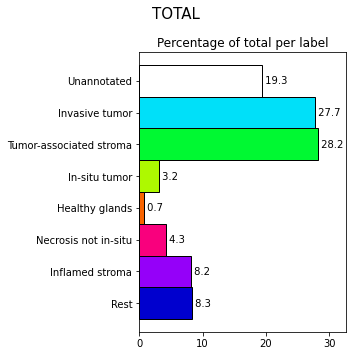

In [172]:
counts_total = df_counts[label_names].sum()
plot_percentages(counts_total, "TOTAL")

---
---
# Split

##### The logic in brief
nnUNet usually splits the training data in 5 random splits. However, we think ist better to have 5 CV splits that have about equal label distributions. Especially because some classes may be quite under represented. 

To make sure we have equal class abundances in the 5 folds, we'll test 500 seeds of 5 fold splits where we: 
- check the abundances of the classes in these splits
- calculate the 5 distances of the folds' pixel counts to the mean of pixel counts of the 5 folds
    - We use MSE loss to calculate the distance of a fold to the mean
    - A low loss means the fold is close to the mean
- Calculate the mean of the 5 losses
- Print the seeds with the lowest losses
    - A low loss means that the distances of the 5 folds to their mean are small, meaning they are about the same
- You can visualise the train and val label distributions in the end. If you agree its good, use this seed to make the splits json/pkl files 

##### Final note
You can chose to split the 5 folds treating every roi as an individual training case, or you can chose to group ROIs from a single WSI together so they cannot end up in the train and val split of the same fold (recommended).

In [173]:
from sklearn.model_selection import KFold

In [174]:
def plot_train_val_fold_counts(counts_train, counts_val, title, label_names=label_names):
    fig, axs = plt.subplots(1, 2, figsize=(15,5))
    fig.suptitle(title, fontsize=15)
    for i_counts, counts in enumerate([counts_train, counts_val]):
        bar_list = axs[i_counts].barh(label_names, counts, height=1) #, height=0.95, log=True)
        for i_bar, bar in enumerate(bar_list):
            bar.set_color(cmap(label_index[i_bar]))
            bar.set_edgecolor("black")
        axs[i_counts].invert_yaxis()
        axs[i_counts].set_title(f"{'TRAIN - ' if i_counts == 0 else 'VAL - '}Pixels per label total (x 100 000)")
        n = len(label_names)
        for i_label in range(n):
            axs[i_counts].text(counts[i_label], i_label, s=" " + str(round(counts[i_label]/100000, 2)) if counts[i_label] !=0.0 else "", 
                     ha="left", va="center")
        axs[i_counts].set_xlim(0, axs[i_counts].get_xlim()[1] + axs[i_counts].get_xlim()[1]*0.1)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.tight_layout()
    plt.show()

## Loss on distributions

In [175]:
import torch

In [176]:
def array_to_formatted_tensor(array):
    tens = torch.tensor(np.array([array]))
    return tens

### Claculate the mean MSE losses over percentages of indivudual folds and their mean
if this mean distance is small it means that the 5 folds' label percentages are close to the mean, meaning they are about the same. We want the seed where this loss is the lowest

In [177]:
def counts_list_and_mean_to_loss(counts_list, counts_mean, log=False):
    loss = torch.nn.MSELoss(reduction='none') # feel free to try other losses
    loss_per_fold_list = []
    for counts in counts_list:
        loss_per_fold = loss(array_to_formatted_tensor(counts), 
                             array_to_formatted_tensor(counts_mean))
        if log:         
            loss_per_fold_list.append(np.log10(loss_per_fold + 0.00000001))
        else:
            loss_per_fold_list.append(loss_per_fold)
        # print(np.log(loss_per_fold))
    # print(loss_per_fold_list)
    mean_loss = torch.cat(loss_per_fold_list).mean()
    # mean_loss = np.mean(loss_per_fold_list)
    return mean_loss

### Split ROIs individually or grouped based on their WSI (advised to chose WSI to prevent train and validation data mixup --> overfitting)

In [178]:
wsi_or_roi_based = 'wsi' # 'roi'

### WSI based

In [179]:
if wsi_or_roi_based == 'wsi':
    important_classes = label_names

    percentages = True

    train_distribution_losses = []
    train_distribution_losses_log = []
    val_distribution_losses = []
    val_distribution_losses_log = []
    for i in range(500):
        random_state= i

        df_wsi_counts['val_fold'] = [None]*len(df_wsi_counts)
        folds=5
        fold_splits = {}

        k5 = KFold(n_splits=folds, shuffle=True, random_state=i) 
        for fold, indexes in enumerate(k5.split(df_wsi_counts['wsi'])):
            fold_splits[fold] = indexes 
            df_wsi_counts.loc[fold_splits[fold][1], 'val_fold'] = fold
        train_counts_list = []
        val_counts_list = []
        for fold in range(folds):
            counts_train = list(df_wsi_counts.loc[fold_splits[fold][0], important_classes].sum())
            if percentages == True:
                counts_train = np.array(counts_train)/sum(counts_train)
            train_counts_list.append(counts_train)
            counts_val = list(df_wsi_counts.loc[fold_splits[fold][1], important_classes].sum())
            if percentages == True:
                counts_val = np.array(counts_val)/sum(counts_val)
            val_counts_list.append(counts_val)

        train_counts_mean = np.mean(train_counts_list, 0)
        train_distribution_loss = counts_list_and_mean_to_loss(train_counts_list, train_counts_mean)
        train_distribution_losses.append(float(train_distribution_loss))
        train_distribution_loss_log = counts_list_and_mean_to_loss(train_counts_list, train_counts_mean, log=True)
        train_distribution_losses_log.append(float(train_distribution_loss_log))

        val_counts_mean = np.mean(val_counts_list, 0)
        val_distribution_loss = counts_list_and_mean_to_loss(val_counts_list, val_counts_mean)
        val_distribution_losses.append(float(val_distribution_loss))
        val_distribution_loss_log = counts_list_and_mean_to_loss(val_counts_list, val_counts_mean, log=True)
        val_distribution_losses_log.append(float(val_distribution_loss_log))

In [180]:
def print_best_dist_loss(dist_losses):
    idx = dist_losses.index(min(dist_losses))
    print(idx, ':', dist_losses[idx])

In [181]:
if wsi_or_roi_based == 'wsi':
    print_best_dist_loss(train_distribution_losses)
    print_best_dist_loss(train_distribution_losses_log)

343 : 8.64864680354427e-06
453 : -5.735637971233006


In [182]:
if wsi_or_roi_based == 'wsi':
    print_best_dist_loss(val_distribution_losses)
    print_best_dist_loss(val_distribution_losses_log)

343 : 0.00014826939624731596
122 : -4.577769866366427


#### I often visualise all of the seeds above (check code below) to check which one I like the most. Often a seed occurs multiple times, probably the best

### ROI based

In [183]:
if wsi_or_roi_based == 'roi':
    important_classes = label_names

    percentages = True

    train_distribution_losses = []
    train_distribution_losses_log = []
    val_distribution_losses = []
    val_distribution_losses_log = []
    for i in range(500):
        random_state= i

        df_counts['val_fold'] = [None]*len(df_counts)
        folds=5
        fold_splits = {}

        k5 = KFold(n_splits=folds, shuffle=True, random_state=i) 
        for fold, indexes in enumerate(k5.split(df_counts['wsi_roi_stem'])):
            fold_splits[fold] = indexes 
            df_counts.loc[fold_splits[fold][1], 'val_fold'] = fold
        train_counts_list = []
        val_counts_list = []
        for fold in range(folds):
            counts_train = list(df_counts.loc[fold_splits[fold][0], important_classes].sum())
            if percentages == True:
                counts_train = np.array(counts_train)/sum(counts_train)
            train_counts_list.append(counts_train)
            counts_val = list(df_counts.loc[fold_splits[fold][1], important_classes].sum())
            if percentages == True:
                counts_val = np.array(counts_val)/sum(counts_val)
            val_counts_list.append(counts_val)

        train_counts_mean = np.mean(train_counts_list, 0)
        train_distribution_loss = counts_list_and_mean_to_loss(train_counts_list, train_counts_mean)
        train_distribution_losses.append(float(train_distribution_loss))
        train_distribution_loss_log = counts_list_and_mean_to_loss(train_counts_list, train_counts_mean, log=True)
        train_distribution_losses_log.append(float(train_distribution_loss_log))

        val_counts_mean = np.mean(val_counts_list, 0)
        val_distribution_loss = counts_list_and_mean_to_loss(val_counts_list, val_counts_mean)
        val_distribution_losses.append(float(val_distribution_loss))
        val_distribution_loss_log = counts_list_and_mean_to_loss(val_counts_list, val_counts_mean, log=True)
        val_distribution_losses_log.append(float(val_distribution_loss_log))

In [184]:
def print_best_dist_loss(dist_losses):
    idx = dist_losses.index(min(dist_losses))
    print(idx, ':', dist_losses[idx])

In [185]:
if wsi_or_roi_based == 'roi':
    print_best_dist_loss(train_distribution_losses)
    print_best_dist_loss(train_distribution_losses_log)

In [186]:
if wsi_or_roi_based == 'roi':
    print_best_dist_loss(val_distribution_losses)
    print_best_dist_loss(val_distribution_losses_log)

# Final split

### Make sure you add your best seed below

### WSI based

In [187]:
if wsi_or_roi_based == 'wsi':
    random_state= 343 # <- for all data : 343
else: 
    print('set to split based on ROI, not WSI')

[  3  11  12  14  20  27  29  31  40  45  48  53  59  61  67  71  72  73
  80  85  87  94  95  97 102 112 117 136 141 142 153 155 158 159 168 182
 183 188 190]


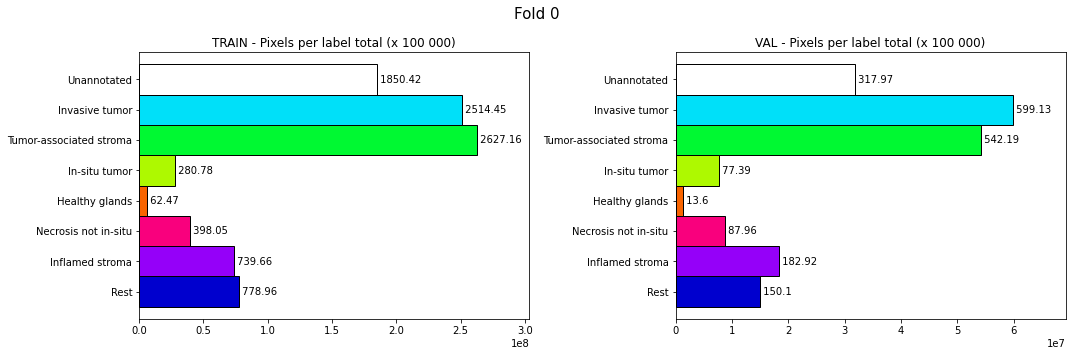

[  1   4   6   7  16  19  23  24  28  30  32  33  41  55  56  57  64  68
  69  75  76  81  91  99 107 109 115 122 127 129 134 138 139 143 148 157
 170 175 180]


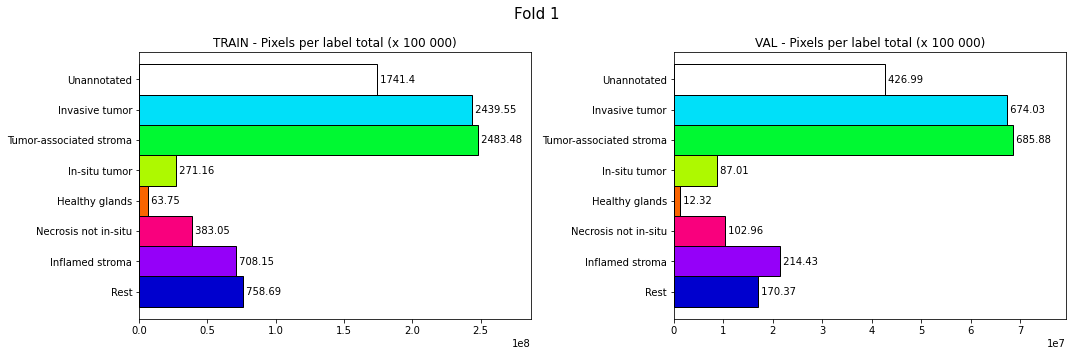

[  8   9  10  15  26  35  36  44  46  50  52  70  84  86  89  90 100 101
 103 106 111 118 120 124 128 135 137 144 145 149 156 160 161 171 173 179
 189 193 194]


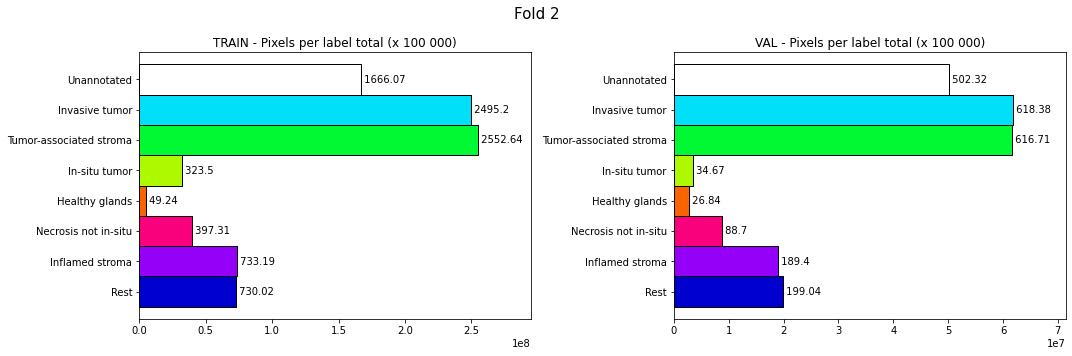

[  0   2  17  18  25  37  42  47  49  54  58  60  66  77  78  82  83  88
  93  96  98 104 105 119 121 123 126 131 133 154 162 165 166 167 169 177
 185 186 187]


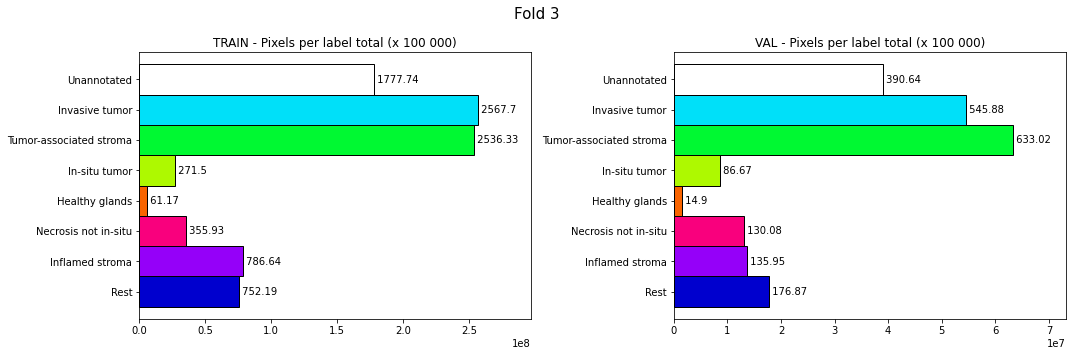

[  5  13  21  22  34  38  39  43  51  62  63  65  74  79  92 108 110 113
 114 116 125 130 132 140 146 147 150 151 152 163 164 172 174 176 178 181
 184 191 192]


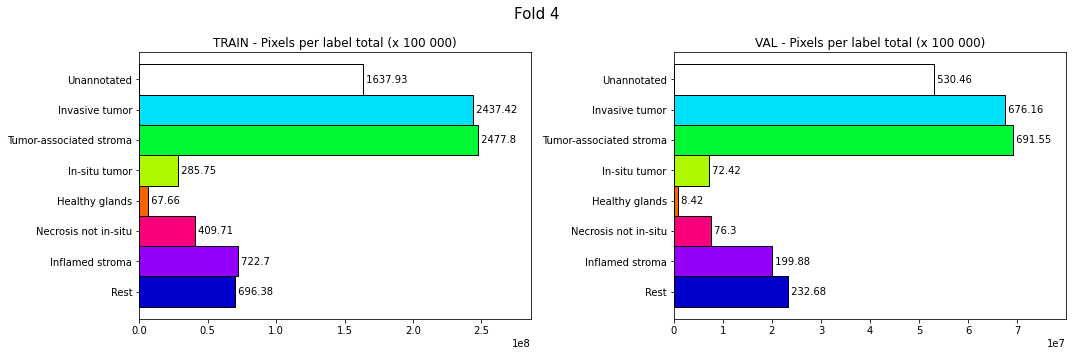

In [188]:
if wsi_or_roi_based == 'wsi':
    important_classes=label_names
    df_wsi_counts['val_fold'] = [None]*len(df_wsi_counts)
    folds=5
    fold_splits = {}

    k5 = KFold(n_splits=folds, shuffle=True, random_state=random_state) 
    for fold, indexes in enumerate(k5.split(df_wsi_counts['wsi'])):
        fold_splits[fold] = indexes 
        df_wsi_counts.loc[fold_splits[fold][1], 'val_fold'] = fold
    train_counts_list = []
    val_counts_list = []
    for fold in range(folds):
        print(fold_splits[fold][1])
        counts_train = list(df_wsi_counts.loc[fold_splits[fold][0], important_classes].sum())
        train_counts_list.append(counts_train)
        counts_val = list(df_wsi_counts.loc[fold_splits[fold][1], important_classes].sum())
        val_counts_list.append(counts_val)
        title = f'Fold {fold}'
        plot_train_val_fold_counts(counts_train, counts_val, title, label_names=important_classes)
else: 
    print('set to split based on ROI, not WSI')

### ROI based

In [189]:
if wsi_or_roi_based == 'roi':
    random_state= 367
else: 
    print('set to split based on WSI, not ROI')

set to split based on WSI, not ROI


In [190]:
if wsi_or_roi_based == 'roi':
    important_classes=label_names

    df_counts['val_fold'] = [None]*len(df_counts)

    folds=5
    fold_splits = {}

    k5 = KFold(n_splits=folds, shuffle=True, random_state=random_state) 
    for fold, indexes in enumerate(k5.split(df_counts['wsi_roi_stem'])):
        fold_splits[fold] = indexes 
        df_counts.loc[fold_splits[fold][1], 'val_fold'] = fold
    train_counts_list = []
    val_counts_list = []
    for fold in range(folds):
        counts_train = list(df_counts.loc[fold_splits[fold][0], important_classes].sum())
        train_counts_list.append(counts_train)
        counts_val = list(df_counts.loc[fold_splits[fold][1], important_classes].sum())
        val_counts_list.append(counts_val)
        title = f'Fold {fold}'
        plot_train_val_fold_counts(counts_train, counts_val, title, label_names=important_classes)
else: 
    print('set to split based on WSI, not ROI')

set to split based on WSI, not ROI


## Prep split json/pkl
json for readability, pkl is used by nnUNet

In [191]:
from collections import OrderedDict

In [192]:
from batchgenerators.utilities.file_and_folder_operations import load_pickle, save_pickle

In [193]:
if wsi_or_roi_based == 'wsi':
    df_counts['val_fold'] = [None]*len(df_counts)
    for fold in range(folds):
        val = list(df_wsi_counts[df_wsi_counts['val_fold']==fold]['wsi'])
        idx = df_counts[df_counts['wsi'].isin(val)].index
        df_counts.loc[idx, 'val_fold'] = fold
else: 
    print('set to split based on ROI, not WSI')

In [194]:
if wsi_or_roi_based == 'roi':
    df_counts['val_fold'] = [None]*len(df_counts)
    for fold in range(folds):
        idx = fold_splits[fold][1]
        df_counts.loc[idx, 'val_fold'] = fold
else: 
    print('set to split based on WSI, not ROI')

In [195]:
data_split_json = []
for fold in range(folds):
    val = list(df_counts[df_counts['val_fold']==fold]['roi_name'])
    train = list(df_counts[df_counts['val_fold']!=fold]['roi_name'])
    data_split_json.append(OrderedDict(train=train, val=val))
# data_split_json

### Save the JSON and PKL split files in the preprocessed folder 
#### This is where nnUNet looks for it, if there is no split file, it does a random split

In [54]:
os.makedirs(os.path.join(preprocessed_root, task_name), exist_ok=True)
data_split_json_path = os.path.join(preprocessed_root, task_name, "splits_final.json")
data_split_pkl_path = os.path.join(preprocessed_root, task_name, "splits_final.pkl")
with open(data_split_json_path, "w") as fp:
    json.dump(fp=fp, obj=data_split_json)
save_pickle(data_split_json, data_split_pkl_path)

---
---
# Make nifti files

### Transform to nifti function

In [55]:
def convert_2d_image_to_nifti(input_filename: str, output_filename_truncated: str, spacing=(999, 1, 1),
                              transform=None, is_seg: bool = False) -> None:
    """
    Reads an image (must be a format that it recognized by skimage.io.imread) and converts it into a series of niftis.
    The image can have an arbitrary number of input channels which will be exported separately (_0000.nii.gz,
    _0001.nii.gz, etc for images and only .nii.gz for seg).
    Spacing can be ignored most of the time.
    !!!2D images are often natural images which do not have a voxel spacing that could be used for resampling. These images
    must be resampled by you prior to converting them to nifti!!!
    Datasets converted with this utility can only be used with the 2d U-Net configuration of nnU-Net
    If Transform is not None it will be applied to the image after loading.
    Segmentations will be converted to np.uint32!
    :param is_seg:
    :param transform:
    :param input_filename:
    :param output_filename_truncated: do not use a file ending for this one! Example: output_name='./converted/image1'. This
    function will add the suffix (_0000) and file ending (.nii.gz) for you.
    :param spacing:
    :return:
    """
    # img = io.imread(input_filename)
    img = input_filename

    if transform is not None:
        img = transform(img)

    if len(img.shape) == 2:  # 2d image with no color channels
        img = img[None, None]  # add dimensions
    else:
        assert len(img.shape) == 3, "image should be 3d with color channel last but has shape %s" % str(img.shape)
        # we assume that the color channel is the last dimension. Transpose it to be in first
        img = img.transpose((2, 0, 1))
        # add third dimension
        img = img[:, None]

    # image is now (c, x, x, z) where x=1 since it's 2d
    if is_seg:
        assert img.shape[0] == 1, 'segmentations can only have one color channel, not sure what happened here'

    for j, i in enumerate(img):

        if is_seg:
            # print(i)
            i = i.astype(np.uint32)
            # print(i)

        itk_img = sitk.GetImageFromArray(i)
        itk_img.SetSpacing(list(spacing)[::-1])
        if not is_seg:
            sitk.WriteImage(itk_img, output_filename_truncated + "_%04.0d.nii.gz" % j)
#             print(itk_img)
        else:
            sitk.WriteImage(itk_img, output_filename_truncated + ".nii.gz")
#             print(itk_img)

In [65]:
verbose = False
start_at = 0

In [66]:
for ia_idx, (i, a) in enumerate(train_image_anno_rois[start_at:]):
    # if verbose:
    #     print('Loading WSA')
    s = Path(a).stem
    if verbose:
        print(f'[{ia_idx+1+start_at}/{len(train_image_anno_rois)}]\t',  s)
    
    # Check if all nifti conversions were alredy done
    output_filename = s 
    if [file for file in os.listdir(label_folder) if file.startswith(output_filename)]: # if the segmentation file is made (is made last), skip
        if verbose:
            print("\t[Skipping] nifti files already existed for", s)
        continue
    if verbose:
        print('loading images')
    roi_patch = np.array(Image.open(i))
    mask_patch = np.array(Image.open(a))
            
    # MAKE OUTPUT
    if verbose:
        print('Start conversion image')
    # print(output_filename)
    convert_2d_image_to_nifti(roi_patch, os.path.join(image_folder, output_filename))
    if verbose:
        print('Start conversion label')
    convert_2d_image_to_nifti(mask_patch, os.path.join(label_folder, output_filename), is_seg=True)
    print("\tnifti files created for", s)
print("DONE")

	nifti files created for TCGA-BH-A1F6-01Z-00-DX1.E83F0DC0-EA2C-4641-81B0-8702B9C5D579_[26906, 24954, 29942, 27302]
	nifti files created for TCGA-BH-A1FC-01Z-00-DX1.B816A21B-1559-42F5-902A-A1532E59C015_[26110, 16680, 29588, 18768]
	nifti files created for TCGA-BH-A42U-01Z-00-DX1.130D060A-3DD8-407E-B8B0-EBBF743491AE_[36029, 44325, 37195, 44971]
	nifti files created for TCGA-C8-A12V-01Z-00-DX1.84B29360-B87B-4648-A697-B6610336C2BB_[5530, 27203, 9336, 29567]
	nifti files created for TCGA-C8-A131-01Z-00-DX1.5CB27A29-9951-40B9-B4DB-26A4D2EA89B8_[21527, 5449, 23121, 6792]
	nifti files created for TCGA-C8-A1HJ-01Z-00-DX1.745159F1-85E7-4CC0-B088-E1CA91916FB8_[23208, 8589, 25914, 10328]
	nifti files created for TCGA-C8-A26X-01Z-00-DX1.FBD86F91-BAD7-4484-8D50-202340FBF242_[4498, 13776, 7553, 17906]
	nifti files created for TCGA-C8-A26Y-01Z-00-DX1.166EE604-4EF3-401D-99E9-3A9711316CC4_[14878, 18388, 17970, 21037]
	nifti files created for TCGA-C8-A27B-01Z-00-DX1.5A8A14E8-6430-4147-9C71-805024E098CB_[

# Loop for saving nifi using WSI loop, BE WARNED
### Dont save nifti files using both loops, this will cause duplicates in your training data. 
I wanted to leave this code here as an option for other applications where only WSI and xml's are available

In [161]:
# for ia_idx, (i, a) in enumerate(train_image_anno[start_at:]):
#     all_done = True
#     if verbose:
#         print('Loading WSA')
#     wsa = WholeSlideAnnotation(a, parser=parser)
#     s = Path(a).stem
#     print(f'[{ia_idx+1+start_at}/{len(train_image_anno)}]\t',  s)
    
#     # Check if all nifti conversions were alredy done
#     for idx, anno in enumerate(wsa.sampling_annotations):
#         output_filename = s + "_ROI" + str(idx)
#         if not [file for file in os.listdir(label_folder) if file.startswith(output_filename)]: # if we cannot find the segemtnation nifti, not all conversions are done
#             all_done = False
#     if all_done == True:
#         # print("\t[Skipping] nifti files already exist for this WSI")
#         continue
    
#     if verbose:
#         print('Loading WSI')
#     # If not all files were converted already, load wsi and convert  
#     wsi = WholeSlideImage(i, backend='asap')
#     for idx, anno in enumerate(wsa.sampling_annotations):
#         output_filename = s + "_ROI" + str(idx)
#         if [file for file in os.listdir(label_folder) if file.startswith(output_filename)]: # if the segmentation file is made (is made last), skip
#             print("\t[Skipping] nifti files already existed for roi", idx)
#             continue
#         roi_patch = wsi.get_annotation(anno, 0.5)
        
#         if verbose: 
#             print(idx, 'loading mask')
#         seg_ratio= 1
#         mask_patch = label_sampler.sample(wsa, Point(anno.center), reversed(roi_patch.shape[:2]), ratio=seg_ratio) 
        
#         # MAKE OUTPUT
#         if verbose:
#             print('Start conversion image')
#         # print(output_filename)
          # print('not saving, just to be safe, make nifti files using this OR the previous loop. Comment out the following line to save using this loop')
#         ##### convert_2d_image_to_nifti(roi_patch, os.path.join(image_folder, output_filename))
#         if verbose:
#             print('Start conversion label')
#         # print('not saving, just to be safe, make nifti files using this OR the previous loop. Comment out the following line to save using this loop')
#         ##### convert_2d_image_to_nifti(mask_patch, os.path.join(label_folder, output_filename), is_seg=True)
        
#         print("\tnifti files created for roi", idx)
# print("DONE")

---
---
# Create dataset json
wait till nifi conversion is completed

### Function for dataset json

In [69]:
def GenerateJson(dataset_path):
    dataset = {}
    dataset['name'] = 'immunotherapy_pilot'
    dataset['description'] = 'Lung Tissue Segmentation in H&E stained whole slide images. This time with improved annotations (30-01-2022)'
    dataset['reference'] = 'Radboud University Medical Center '
    dataset['licence'] = 'XXXX'
    dataset['relase'] = 'X.XX'
    dataset['tensorImageSize'] = '2D'
    dataset['modality'] = {
        "0": "R Histopathology",
        "1": "G Histopathology",
        "2": "B Histopathology"}
    
    dataset['labels'] = {str(n) : label_names[n] for n in range(n_labels)}

    dataset['training'] = []
    dataset['test'] = []
    images_path = os.path.join(dataset_path, 'imagesTr')

    filelist = os.listdir(images_path)
    filelist = [re.sub(r'_000\d', '', f) for f in filelist]
    filelist = np.unique(filelist)

    for f in filelist:
        json_imagetr = './' + 'imagesTr/' + f
        json_mask = './' + 'labelsTr/' + f

        dataset['training'].append({
            'image': json_imagetr,
            'label': json_mask
        })


    dataset['numTraining'] = len(filelist)
    json_path = os.path.join(dataset_path, 'dataset.json')
    with open(json_path, 'w') as outfile:
        json.dump(dataset, outfile, indent=4)

### Make dataset json

In [71]:
print(task_root)
GenerateJson(task_root)

/data/pathology/projects/pathology-lung-TIL/nnUNet_raw_data_base/nnUNet_raw_data/Task027_TIGER_public_test


---
---
# Run nnUNet

In [73]:
print("TASK:\t\t", task_name)
print("nnUNet ROOT:\t", nnUNet_base)

TASK:		 Task027_TIGER_public_test
nnUNet ROOT:	 /data/pathology/projects/pathology-lung-TIL/nnUNet_raw_data_base


## Set trainer, and experiment planner
These are used to print the commands you need to run

If the proposed experiment planner doesnt work doesnt fit your GPU (we used 10/11 GB), we advise you to use the default planner and check on the batch and patch size it returns. You can then try bigger batch size with a smaller patch size, which is the same approach wee took during our experimental phase.

#### Trainer
*Best: nnUNetTrainerV2_BN_pathology_DA_ignore0_hed005*

You can check out other trainers as well. Or get some idea on how to change/ create your own trainers

In [ ]:
# trainer_name = 'nnUNetTrainerV2' #default
# trainer_name = 'nnUNetTrainerV2_BN' # with batch norm
# trainer_name = 'nnUNetTrainerV2_ignore0' # ignore label 0 in loss calculation
# trainer_name = 'nnUNetTrainerV2_BN_pathology_DA_hed005' # batch norm and 
trainer_name = 'nnUNetTrainerV2_BN_pathology_DA_ignore0_hed005' #best, batch norm, ignore0, and HED augmentation
# trainer_name = 'nnUNetTrainerV2_BN_pathology_DA_hed005_hsv010' # 

#### Experiment planner class, and Plans file name (created by the experiment planner class)
*Best: ExperimentPlanner2D_v21_RGB_scaleTo_0_1_bs8_ps512, nnUNet_RGB_scaleTo_0_1_bs8_ps512*

In [42]:
experiment_planner, experiment_planner_identifier = '', '' # this is a compatibility wrapper of the default
# experiment_planner, experiment_planner_identifier = 'ExperimentPlanner2D_v21_RGB_z_score_default_bs2_ps1024', 'nnUNet_RGB_z_score_default_bs2_ps1024' # this is a compatibility wrapper of the default with set bs ps
# experiment_planner, experiment_planner_identifier = 'ExperimentPlanner2D_v21_RGB_scaleTo_0_1', 'nnUNet_RGB_scaleTo_0_1'
# experiment_planner, experiment_planner_identifier = 'ExperimentPlanner2D_v21_RGB_scaleTo_0_1_bs2_ps1024', 'nnUNet_RGB_scaleTo_0_1_bs2_ps1024' # found by default with gpu of 11GB
# experiment_planner, experiment_planner_identifier = 'ExperimentPlanner2D_v21_RGB_scaleTo_0_1_bs8_ps512', 'nnUNet_RGB_scaleTo_0_1_bs8_ps512' # best tested configuration, however
# experiment_planner, experiment_planner_identifier = 'ExperimentPlanner2D_v21_RGB_scaleTo_0_1_bs32_ps256', 'nnUNet_RGB_scaleTo_0_1_bs32_ps256'

# Plan and preprocess

In [43]:
# If you havent already, run this or something similar in terminal to set your environment variables 
print(f'export nnUNet_raw_data_base={nnUNet_base}')
print(f'export nnUNet_preprocessed={preprocessed_root}')
print(f"export RESULTS_FOLDER={os.path.join(nnUNet_base, 'results')}")

export nnUNet_raw_data_base=/data/pathology/projects/pathology-lung-TIL/nnUNet_raw_data_base
export nnUNet_preprocessed=/data/pathology/projects/pathology-lung-TIL/nnUNet_raw_data_base/nnUNet_preprocessed
export RESULTS_FOLDER=/data/pathology/projects/pathology-lung-TIL/nnUNet_raw_data_base/results


#### Run the following command to plan your experiment and preprocess your data

In [46]:
cmd = ['nnUNet_plan_and_preprocess',
      '-t', task_id,
      # '-tl', '1', # most probably you can increase this
      # '-tf', '1', # most probably you can increase this
      f'-pl2d {experiment_planner}' if experiment_planner else '',
      '-pl3d', 'None',
      '--verify_dataset_integrity']
print(' '.join(cmd))

nnUNet_plan_and_preprocess -t 027  -pl3d None --verify_dataset_integrity


In [40]:
print('example:\n', 
      'nnUNet_plan_and_preprocess -t 027 -tl 1 -tf 1 -pl2d ExperimentPlanner2D_v21_RGB_scaleTo_0_1_bs8_ps512 -pl3d None --verify_dataset_integrity')

example:
 nnUNet_plan_and_preprocess -t 027 -tl 1 -tf 1 -pl2d ExperimentPlanner2D_v21_RGB_scaleTo_0_1_bs8_ps512 -pl3d None --verify_dataset_integrity


# Train

#### Run the following commands to train the 5 folds
Note: 
- if your training is interrupted and you need to *continue* training add -c to the command. Done automatically in the code below but still worth mentioning
- you can also run with fold='all' to train on all data (no cv)

In [196]:
for fold in range(5):
    cmd = ['nnUNet_train',
           '2d',
           trainer_name,
           task_id,
           str(fold)]
    outdir = os.path.join(nnUNet_base, 'results', 'nnUNet', '2d', task_name, f'{trainer_name}__{experiment_planner_identifier}', 'all' if fold=='all' else f'fold_{fold}')
    if os.path.isdir(outdir) and any(Path(outdir).glob("*.model")):
        cmd.append('-c')
    cmd.append(f'-p {experiment_planner_identifier}')
    print(' '.join(cmd))

nnUNet_train 2d nnUNetTrainerV2_BN_pathology_DA_ignore0_hed005 027 0 -c -p nnUNet_RGB_scaleTo_0_1_bs8_ps512
nnUNet_train 2d nnUNetTrainerV2_BN_pathology_DA_ignore0_hed005 027 1 -p nnUNet_RGB_scaleTo_0_1_bs8_ps512
nnUNet_train 2d nnUNetTrainerV2_BN_pathology_DA_ignore0_hed005 027 2 -p nnUNet_RGB_scaleTo_0_1_bs8_ps512
nnUNet_train 2d nnUNetTrainerV2_BN_pathology_DA_ignore0_hed005 027 3 -p nnUNet_RGB_scaleTo_0_1_bs8_ps512
nnUNet_train 2d nnUNetTrainerV2_BN_pathology_DA_ignore0_hed005 027 4 -p nnUNet_RGB_scaleTo_0_1_bs8_ps512


In [141]:
print('example:\n', 
      'nnUNet_train 2d nnUNetTrainerV2_BN_pathology_DA_ignore0_hed005 027 0 -p nnUNet_RGB_scaleTo_0_1_bs8_ps512')

example:
 nnUNet_train 2d nnUNetTrainerV2_BN_pathology_DA_ignore0_hed005 027 0 -p nnUNet_RGB_scaleTo_0_1_bs8_ps512
